#Import Required Libraries

In [55]:
#Install & Use Pydeck for Map Visualization
!pip install pydeck

In [56]:
# Data Manipulation
import pandas as pd
import numpy as np

# Big Data Processing
import dask.dataframe as dd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Map-Based Visualizations
import pydeck as pdk
import folium

# Data Scaling
from sklearn.preprocessing import MinMaxScaler

# Deep Learning for Time-Series Prediction
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")


#Load and Explore Dataset

In [57]:
# Mount Google Drive to access dataset from Colab
from google.colab import drive
drive.mount('/content/drive')

# Import Dask for big data processing
import dask.dataframe as dd

#Data Type Declarations
dtypes = {
    'Search Arrest Reason': 'object',
    'Search Disposition': 'object',
    'Search Reason': 'object',
    'Search Type': 'object',
    'Year': 'float64'
}

# Load the large CSV file using Dask (memory-efficient)
# Dask lets us work with big datasets by breaking them into smaller partitions

dask_df = dd.read_csv('/content/drive/MyDrive/AP final case study/Traffic_Violations.csv', dtype=dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Drop missing rows and Fill Missing Values

In [58]:
# Check Null Values Before Cleaning

# Get total number of rows in the dataset
total_before = dask_df.shape[0].compute()

# Count null values in each column, sort in descending order
nulls_before = dask_df.isnull().sum().compute().sort_values(ascending=False)

# Print summary
print("Total Rows Before Cleaning:", total_before)
print("\n Null Values Before Cleaning:\n")
print(nulls_before)

Total Rows Before Cleaning: 2025647

 Null Values Before Cleaning:

Search Arrest Reason       1964403
Search Type                1936969
Search Reason              1936961
Search Disposition         1936961
Search Outcome              788395
Search Reason For Stop      769407
Search Conducted            769104
Article                      91025
Color                        22137
Year                         10574
DL State                       929
Driver City                    517
Model                          221
Make                            73
State                           59
Driver State                    11
Description                     10
Location                         4
Belts                            0
SeqID                            0
Accident                         0
Longitude                        0
Latitude                         0
Agency                           0
SubAgency                        0
Date Of Stop                     0
Time Of Stop          

In [59]:
# Fill Specific Columns with Default Values
dask_df = dask_df.fillna({
    'Search Arrest Reason': 'Unknown',
    'Search Disposition': 'Unknown',
    'Search Reason': 'Unknown',
    'Search Type': 'Unknown',
    'Year': 0
})

# Drop rows with critical nulls
dask_df = dask_df.dropna(subset=["Date Of Stop", "Latitude", "Longitude"])

# Convert Date column (Fixing the Date Format)
dask_df["Date Of Stop"] = dd.to_datetime(dask_df["Date Of Stop"])

# Count Total Rows After Cleaning
total_after = len(dask_df)

In [60]:
#  Check Null Values After Cleaning
nulls_after = dask_df.isnull().sum().compute().sort_values(ascending=False)

# Print summary
print("\n Null Values After Cleaning:\n")
print(nulls_after)
print("\nTotal Rows After Cleaning:", total_after)


 Null Values After Cleaning:

Search Outcome             788395
Search Reason For Stop     769407
Search Conducted           769104
Article                     91025
Color                       22137
DL State                      929
Driver City                   517
Model                         221
Make                           73
State                          59
Driver State                   11
Description                    10
Location                        4
Belts                           0
Latitude                        0
Agency                          0
SubAgency                       0
Date Of Stop                    0
Time Of Stop                    0
SeqID                           0
Accident                        0
Longitude                       0
Work Zone                       0
Personal Injury                 0
Property Damage                 0
Fatal                           0
Commercial License              0
Search Arrest Reason            0
Search Type      

#Daily Traffic Violations Over Time

In [61]:
# 4. Aggregate by Date
daily_violations = dask_df.groupby("Date Of Stop").size().compute().reset_index()
daily_violations.columns = ["Date", "Violation_Count"]
# Sort data
daily_violations = daily_violations.sort_values("Date")
df_lstm = pd.DataFrame(daily_violations)

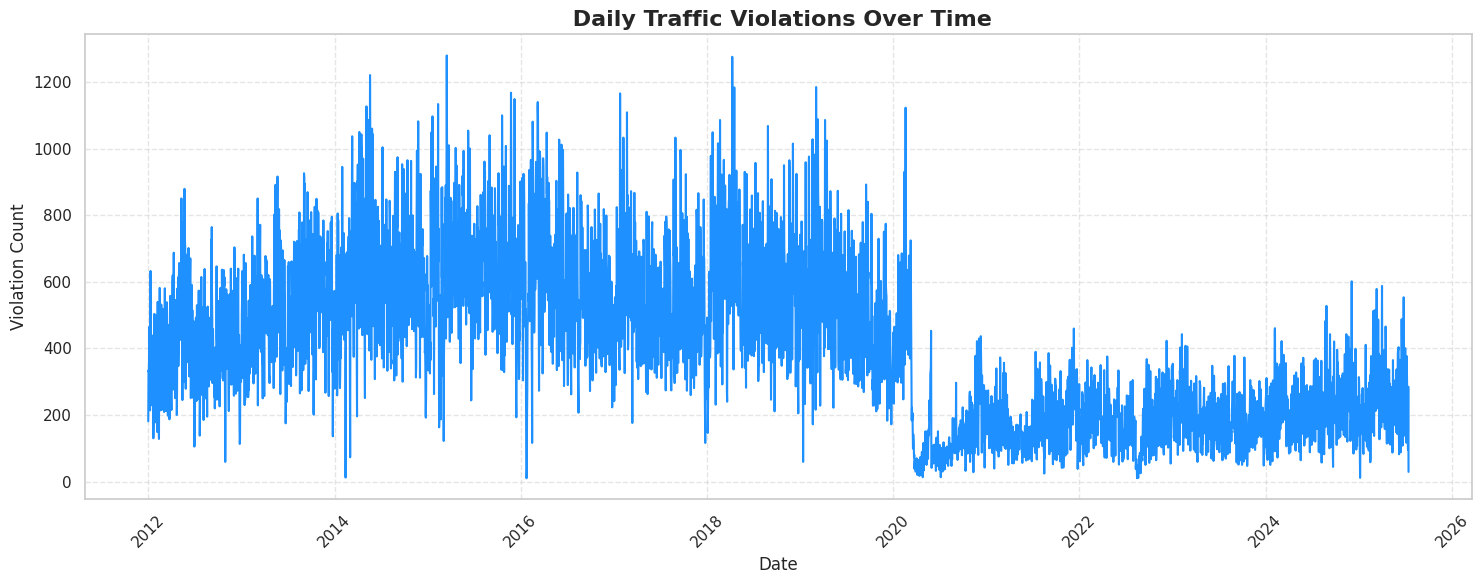

In [62]:

# Set dark theme with better spacing
sns.set(style="whitegrid")

# Convert to datetime
daily_violations["Date"] = pd.to_datetime(daily_violations["Date"])

# Plot with proper dates on x-axis
plt.figure(figsize=(15, 6))
plt.plot(daily_violations["Date"], daily_violations["Violation_Count"], color='dodgerblue', linewidth=1.5)

# Styling
plt.title(" Daily Traffic Violations Over Time", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Violation Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Preparing and Building Data for LSTM

In [63]:
# Prepare Data for LSTM
# Normalize the 'Violation_Count' data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm[["Violation_Count"]])

# Create sequences for LSTM input
X, y = [], []
for i in range(30, len(scaled_data)):
    X.append(scaled_data[i-30:i])
    y.append(scaled_data[i])

# Convert lists to NumPy arrays for model training
X, y = np.array(X), np.array(y)

In [64]:
# 6. Build LSTM Model

# Create a Sequential LSTM model
model = Sequential()

# Add an LSTM layer with 64 units and ReLU activation
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))

# Add a Dense output layer with 1 neuron (for regression)
model.add(Dense(1))

# Compile the model using Adam optimizer and MSE loss (good for regression)
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1)


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0637 - val_loss: 0.0048
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0148 - val_loss: 0.0052
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0136 - val_loss: 0.0051
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0141 - val_loss: 0.0046
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0130 - val_loss: 0.0049
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0125 - val_loss: 0.0046
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0130 - val_loss: 0.0043
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0119 - val_loss: 0.0038
Epoch 9/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0113 - val_loss: 0.0037
Epoch 10/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0109 - val_loss: 0.0034


154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


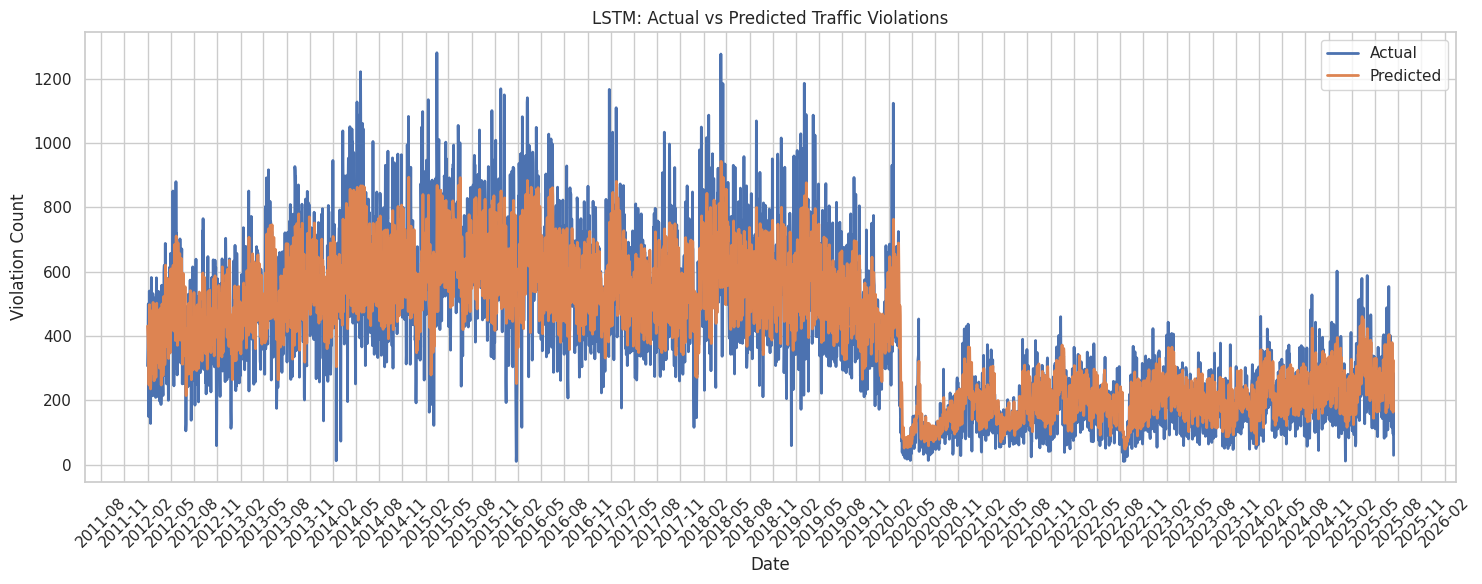

In [65]:
#  7. Make Predictions
y_pred = model.predict(X)
y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y)

# 8. Plot Predictions
dates = df_lstm['Date'].values[-len(y_true_inv):]
plt.figure(figsize=(15,6))
plt.plot(dates, y_true_inv, label="Actual", linewidth=2)
plt.plot(dates, y_pred_inv, label="Predicted", linewidth=2)
plt.title("LSTM: Actual vs Predicted Traffic Violations")
plt.xlabel("Date")
plt.ylabel("Violation Count")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [66]:
#Calculate Mean Squared Error between actual and predicted values
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true_inv, y_pred_inv)
print("MSE:", mse)

MSE: 14751.903225768305


#Map Visualization

In [67]:
# Map Visualization using PyDeck (sample 1000 points)
map_df = dask_df[["Latitude", "Longitude"]].sample(frac=0.0005).compute()  # ~1000 points
map_df = map_df.dropna()

#create Visualization layer
map_layer = pdk.Layer(
    "ScatterplotLayer",
    data=map_df,
    get_position='[Longitude, Latitude]',
    get_radius=100,
    get_fill_color=[255, 0, 0],
    pickable=True
)

#configure map view centred on data
map_view = pdk.ViewState(latitude=map_df["Latitude"].mean(),
                         longitude=map_df["Longitude"].mean(),
                         zoom=9)
#Generate interactive map
deck = pdk.Deck(layers=[map_layer], initial_view_state=map_view, tooltip={"text": "Lat: {Latitude}\nLon: {Longitude}"})
#save to html
deck.to_html("traffic_map.html")

<IPython.core.display.Javascript object>

In [68]:
#Traffic Violation Density Analysis
from folium.plugins import HeatMap

# Sample 5000 rows to keep it fast
sample_df = dask_df[['Latitude', 'Longitude']].dropna().sample(frac=5000/len(dask_df)).compute()

# Create base map
m = folium.Map(location=[39.1547, -77.2405], zoom_start=10)

# Add heatmap
HeatMap(sample_df.values.tolist()).add_to(m)
m #print

#Smart Dashboard with Summary Insights


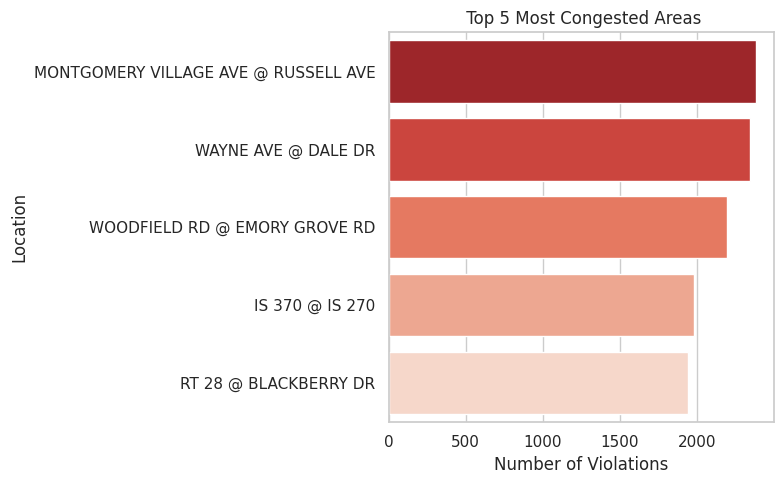

In [69]:
# Count of violations by location
df = dask_df.compute() # Convert Dask DataFrame to pandas DataFrame
top_areas = df['Location'].value_counts().nlargest(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top_areas.values, y=top_areas.index, palette='Reds_r')
plt.title(" Top 5 Most Congested Areas")
plt.xlabel("Number of Violations")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

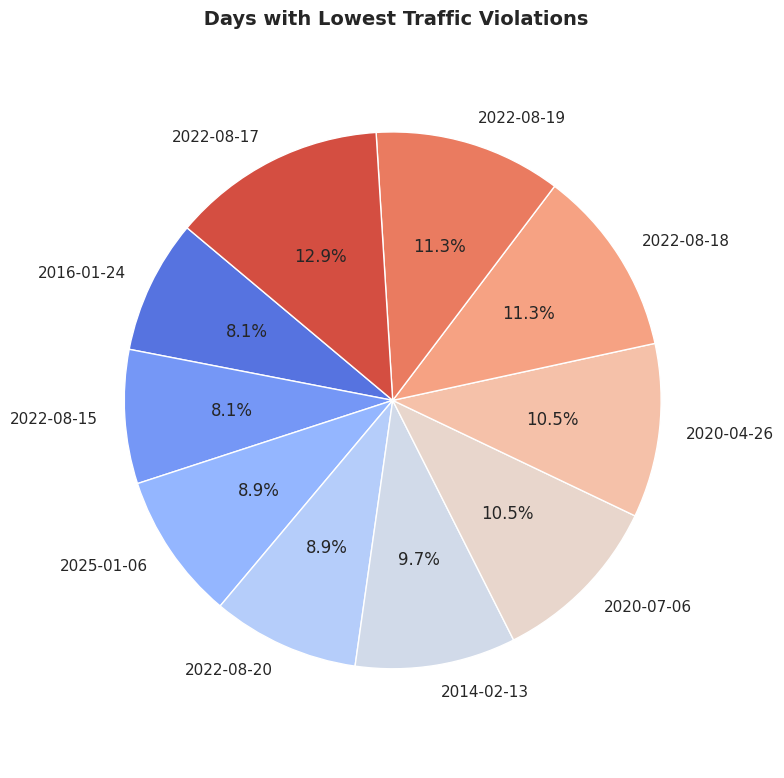

In [70]:
# Group by date and get 10 lowest traffic days
daily_traffic = df.groupby('Date Of Stop').size().sort_values().head(10)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    daily_traffic.values,
    labels=daily_traffic.index.strftime('%Y-%m-%d'),  # Format dates
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('coolwarm', n_colors=10)
)

plt.title(" Days with Lowest Traffic Violations", fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()

